### 前提
```
4種類の特徴量（説明変数）からアヤメの種類を推測する
アヤメの種類を分類 

使うアルゴリズム
- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使う
2次元の散布図を描き確認することができる

問題を単純化するためアヤメの種類を2つだけ使う

目的変数 3c2(3通り) と 特徴量 4c2(6通り) を選び方の組み合わせは合計18通り
目的変数の種類
    Iris setosa
    Iris virgicolor
    Iris virginica
特徴量の種類
    sepal_length
    sepal_width
    petal_length
    petal_width


実際の分析では特徴量を2つに絞るのは望ましくない。
そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われる。
Week3で利用した散布図行列を使い可視化することも可能。

データの分析まではPandasのDataFrameを使うが、scikit-learnはNumPyのndarrayを想定して作られている。
sklearnを使う段階でndarrayに変換を行う。
```

### 【課題1】練習のために特徴量とカテゴリを選択
```
virgicolor と virginica
sepal_length　と petal_length
```

In [153]:
from sklearn.datasets import load_iris
import pandas as pd

iris_dataset = load_iris()
x = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
x = x.loc[:, ["sepal_length", "petal_length"]]
y = pd.Series(iris_dataset.target, name="y")
df_train = x.join(y).query('y in (1,2)')

### 【問題2】データの分析

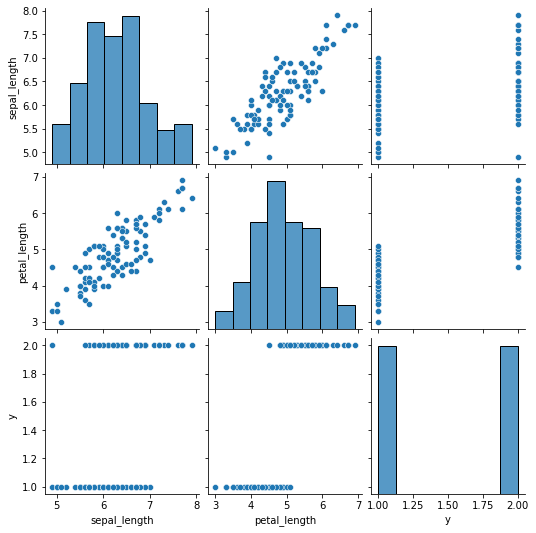

In [154]:
# 散布図
from matplotlib import pyplot as plt
import seaborn as sns

sns.pairplot(df_train)
plt.show()

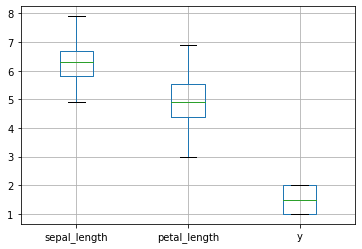

In [7]:
# 箱ひげ図（boxplot）
df_train.plot.box()
plt.grid()
plt.show()

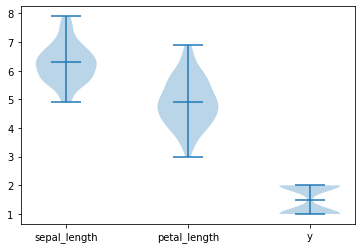

In [8]:
# バイオリン図（violinplot）
plt.violinplot(df_train, showmedians=True)
plt.xticks([1, 2, 3], df_train.columns.values)
plt.show()

### 【問題3】前処理・訓練データと検証データの分割

In [155]:
from sklearn.model_selection import train_test_split

x = df_train.drop(["y"],  axis=1)
y = df_train["y"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=0)

### 【問題4】前処理・標準化

In [156]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_train_raw = x_train
x_test_raw = x_test

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### 【問題5】学習と推定

In [157]:
from sklearn.neighbors import KNeighborsClassifier

preds = []

for i in [1, 2, 3, 4, 5, 9]:
    knc = KNeighborsClassifier(n_neighbors=i)
    knc.fit(x_train, y_train) # 学習
    p = knc.predict(x_test) # 学習結果を元に予測
    print(f"{i}-nn {p}")
    preds.append(p)

1-nn [1 2 2 2 2 2 1 2 2 1 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
2-nn [1 2 1 2 2 2 1 2 2 1 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
3-nn [1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
4-nn [1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
5-nn [1 2 1 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 2 1]
9-nn [1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


### 【問題6】評価

4種類の指標値の意味について簡単に調査して文章でまとめる
```
Accuracy（正解率）
    どれくらい成功していたかを表す単純な指標
    100個のデータが入力されたときに、90個のデータにおいて分類が成功した場合はその分類器のAccuracyは90%
    値が大きいほど精度が高い
    問題
        入力データに偏りがある場合、精度が高いにも関わらず、実際は低い場合がありうる

混合行列
    True Positiv(TP)
        予測値: Positive 真値:Positive
    False Positive (FP)
        予測値: Positive 真値:Negative
    False Negative (FN)
        予測値: Negative 真値:Positive
    True Negative (TN)
        予測値: Negative 真値:Negative
    
Precision（適合率）
    予測値がどれくらい正確であるか
    PrecisionとRecallはトレードオフの関係
    「Positiveと予測したデータ」のうち、本当にPositiveであった確率
    TP / (TP+NP)
Recall（再現率）
    予測値がどれくらい網羅できているか
    PrecisionとRecallはトレードオフの関係
    「Positiveなデータの」うち、Positiveだと予測された確率のことを指します。
    TP / (TP+FN)
F値
    PrecisionとRecallのバランスが良いことが良いモデルになるため、
    そのバランスを取りつつ評価ができる指標
    (2*Precision*Recall)/(Precision+Recall)
```

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

pred = preds[4]
print(y_test.values)
print(pred)

# scikit-learnを使い4種類の指標を計算する
display(f1_score(y_test, pred))
display(recall_score(y_test, pred, zero_division=1))
display(precision_score(y_test, pred, zero_division=1))
display(accuracy_score(y_test, pred))

# 混同行列をscikit-learnを使い表示する
cm = confusion_matrix(y_test, pred)
display(cm)

[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 2 1]
[1 2 1 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 2 1]


0.8695652173913044

0.7692307692307693

1.0

0.88

array([[10,  3],
       [ 0, 12]])

### 【問題7】可視化

In [115]:
# テンプレの関数を定義
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

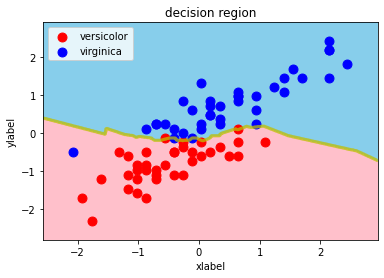

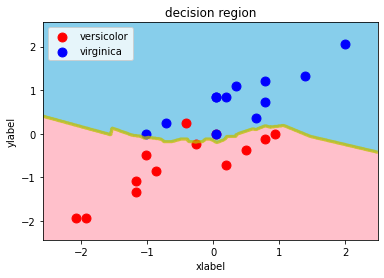

In [116]:
# 可視化の関数実行
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(x_train, y_train) # 学習
p = knc.predict(x_test) # 学習結果を元に予測

decision_region(x_train, y_train, knc)
decision_region(x_test, y_test, knc)

### 【問題8】他の手法の学習

knc:			[1 2 1 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 1 1 2 1 2 1]


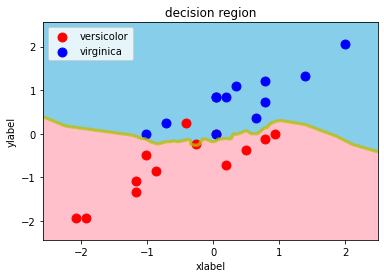

lr :			[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


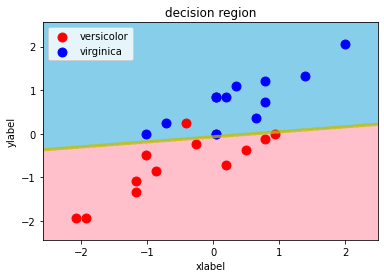

svcmodel :	[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


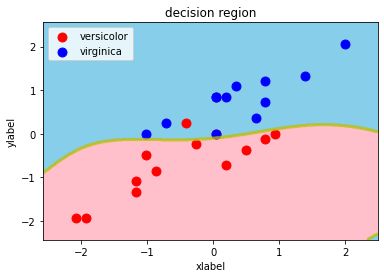

dtc_p :		[1 2 1 2 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 1 2 1 2 1]


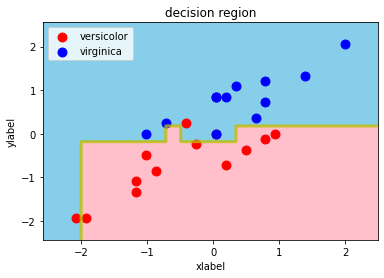

rfc_p :		[1 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]


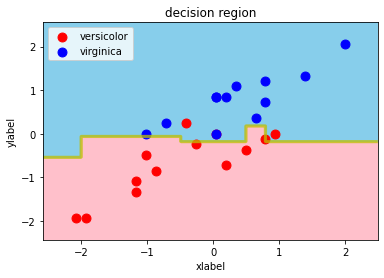

In [167]:
# 最近傍法
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(x_train, y_train)
knc_p = knc.predict(x_test)
print(f"knc:\t\t\t{knc_p}")
decision_region(x_test, y_test, knc)

knc_score = [
    accuracy_score(y_test, knc_p),
    precision_score(y_test, knc_p, zero_division=1),
    recall_score(y_test, knc_p, zero_division=1),
    f1_score(y_test, knc_p)
]

# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_p = lr.predict(x_test)
print(f"lr :\t\t\t{lr_p}")
decision_region(x_test, y_test, lr)
lr_score =  [
    accuracy_score(y_test, lr_p),
    precision_score(y_test, lr_p, zero_division=1),
    recall_score(y_test, lr_p, zero_division=1),
    f1_score(y_test, lr_p)
]


# SVM
from sklearn import svm
svcmodel = svm.SVC()
svcmodel.fit(x_train, y_train)
svcmodel_p = svcmodel.predict(x_test)
print(f"svcmodel :\t{svcmodel_p}")
decision_region(x_test, y_test, svcmodel)
svcmodel_score =  [
    accuracy_score(y_test, svcmodel_p),
    precision_score(y_test, svcmodel_p, zero_division=1),
    recall_score(y_test, svcmodel_p, zero_division=1),
    f1_score(y_test, svcmodel_p)
]


# 決定木
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_p = dtc.predict(x_test)
print(f"dtc_p :\t\t{dtc_p}")
decision_region(x_test, y_test, dtc)
dtc_score =  [
    accuracy_score(y_test, dtc_p),
    precision_score(y_test, dtc_p, zero_division=1),
    recall_score(y_test, dtc_p, zero_division=1),
    f1_score(y_test, dtc_p)
]


# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_p = rfc.predict(x_test)
print(f"rfc_p :\t\t{rfc_p}")
decision_region(x_test, y_test, rfc)
rfc_score =  [
    accuracy_score(y_test, rfc_p),
    precision_score(y_test, rfc_p, zero_division=1),
    recall_score(y_test, rfc_p, zero_division=1),
    f1_score(y_test, rfc_p)
]

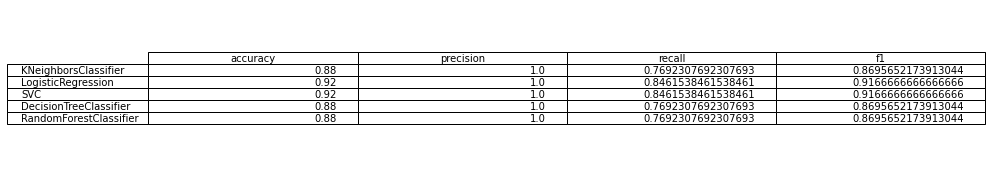

In [168]:
fig, ax =plt.subplots(1,1, figsize=(15, 3))
data = np.array([knc_score, lr_score, svcmodel_score, dtc_score, rfc_score])
column_labels = np.array(["accuracy", "precision", "recall", "f1"])
row_labels = ["KNeighborsClassifier", "LogisticRegression", "SVC", "DecisionTreeClassifier", "RandomForestClassifier"]
ax.axis('tight')
ax.axis('off')
ax.table(cellText=data, colLabels=column_labels, rowLabels=row_labels, loc="center")

plt.show()

> その表と決定領域を利用して結果を簡単に考察してください。  
> どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。
```
概ね左から右にきれいに分割されているが、決定木だけは左部分が不規則に分断されている。
precisionはすべて1.0なため、参考にならず。
ほかすべての指標でLogisticRegとSVCがトップ値になっている。
全体的にサンプルが足りないため、ブレの大きい結果となっている印象がある。
```

### 【問題9】（アドバンス課題）標準化の有無の比較
```
前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。
各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。
考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。
```

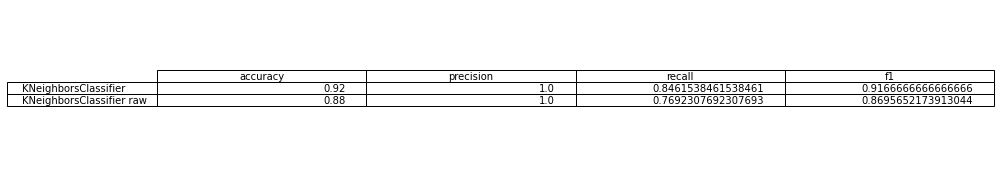

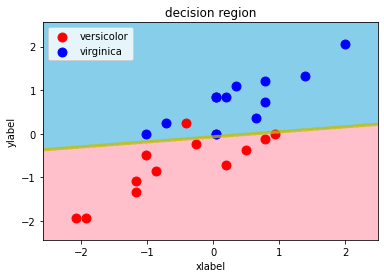

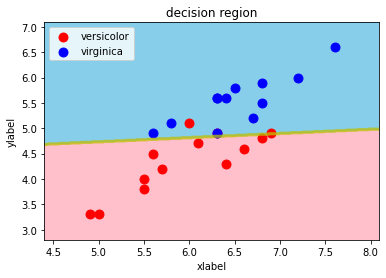

In [175]:
# 標準化していなパターン
lr_raw = LogisticRegression()
lr_raw.fit(x_train_raw, y_train)
lr_p = lr_raw.predict(x_test_raw)
lr_score_raw =  [
    accuracy_score(y_test, lr_p),
    precision_score(y_test, lr_p, zero_division=1),
    recall_score(y_test, lr_p, zero_division=1),
    f1_score(y_test, lr_p)
]

fig, ax =plt.subplots(1,1, figsize=(15, 3))
data = np.array([lr_score, lr_score_raw])
column_labels = np.array(["accuracy", "precision", "recall", "f1"])
row_labels = ["KNeighborsClassifier", "KNeighborsClassifier raw"]
ax.axis('tight')
ax.axis('off')
ax.table(cellText=data, colLabels=column_labels, rowLabels=row_labels, loc="center")
plt.show()

decision_region(x_test, y_test, lr)
decision_region(x_test_raw.values, y_test, lr_raw)

```
▼ 考察
標準化を行わなかった場合、正答率が少し悪くなった。
判定がどちらか微妙だった値が、標準化によって正答側に近づいた。
標準化が機械学習の前処理としては、値の大きさ（スケール）をあわせる効果がある。
```

### 【問題10】（アドバンス課題）すべての目的変数を使用して精度が高い手法

In [2]:
#
# データの準備
#

from sklearn.datasets import load_iris
import pandas as pd

# データセットの準備
iris_dataset = load_iris()

# 特徴量は"sepal_length", "petal_length" の2種類
x = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
x = x.loc[:, ["sepal_length", "petal_length"]]

# 目的変数は 0 (setosa), 1 (virgicolor), 2　(virginica)
y = pd.Series(iris_dataset.target, name="y")

# 1つのdfにまとめる
df_train = x.join(y)

In [3]:
#
# 特徴量エンジニアリング: 特徴量の前処理
#

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# x,y を tiran,test に分割
x = df_train.drop(["y"],  axis=1)
y = df_train["y"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=0)

# 標準化
scaler = StandardScaler()
scaler.fit(x_train)
# x_trainで学習したscalartでx_trainとx_testを標準化
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [66]:
#
# 学習結果の可視化
#

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

def decision_region2(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['lime', 'pink', 'skyblue']
    n_class = 3 # yの種類数(クラス数)

    #
    # 2つの特徴量のmin/maxレンジから細かい単位で、すべての組み合わせのpredictを行い、それを背景色として決定境界を描く
    #
    
    # 特徴量2つのメッシュグリッドを作成
    # mesh_f0, mesh_f1 ともに2次元配列
    # 参考: https://deepage.net/features/numpy-meshgrid.html
    x0_min  = np.min(X[:,0])
    x0_max = np.max(X[:,0])
    x1_min = np.min(X[:,1])
    x1_max = np.max(X[:,1])
    x0_range = np.arange(x0_min-0.5, x0_max+0.5, step) # sepal_length
    x1_range = np.arange(x1_min-0.5, x1_max+0.5, step) # petal_length
    mesh_f0, mesh_f1  = np.meshgrid(x0_range, x1_range)
    # 学習用に配列の形状変換
    # ravel: 2次元配列を1次元配列にする
    # c_: 各indexの同じ要素で1つの配列とし、2次元配列を作る
    # 実質座標を表すようになる？
    # len(mesh) = 172260
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    # おそらく、特徴量の組み合わせを膨大に作って、予測値を算出している
    # mesh_f0.shape: (396, 435)
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    display(ListedColormap(contourf_color))
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # contourf(格子点のx座標の配列, 格子点のy座標の配列, 値の配列)
    # contourf([X, Y,] Z, [levels], **kwargs)
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html
    # エリアの色塗り
    plt.contourf(mesh_f0, mesh_f1, y_pred, levels=n_class-1, cmap=ListedColormap(contourf_color))
    #　境界線の強調
    plt.contour(mesh_f0, mesh_f1, y_pred, levels=n_class-1, colors='y', linewidths=3, alpha=0.5)

    # 
    # 引数のx,yを単純にplotする
    #
    unique_y = set(y) # 0, 1, 2
    for i, target in enumerate(unique_y):  # enumerate: idxとvalueを使える
        tgt_color = scatter_color[i]
        tgt_label = target_names[i]
        a = X[y==target][:, 0]  # sepal_length
        b =  X[y==target][:, 1] # petal_length
        plt.scatter(a, b, s=80, color=tgt_color, label=tgt_label, marker='o')
    # 凡例表示
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches) # これだけだとバーで表示される
    plt.legend() # これを呼ぶと丸になる 謎
    plt.show()

In [2]:
#
# 各アルゴリズムを使う
#

from sklearn.metrics import classification_report

# 最近傍法
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(x_train, y_train)
knc_p = knc.predict(x_test)
decision_region2(x_test, y_test, knc)
report = classification_report(y_test, knc_p, output_dict=True)
knc_report = [
    report["accuracy"],
    report["macro avg"]["precision"],
    report["macro avg"]["recall"],
    report["macro avg"]["f1-score"],
]

# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_p = lr.predict(x_test)
decision_region(x_test, y_test, lr)
report = classification_report(y_test, lr_p, output_dict=True)
lr_report = [
    report["accuracy"],
    report["macro avg"]["precision"],
    report["macro avg"]["recall"],
    report["macro avg"]["f1-score"],
]

# SVM
from sklearn import svm
svcmodel = svm.SVC()
svcmodel.fit(x_train, y_train)
svcmodel_p = svcmodel.predict(x_test)
decision_region(x_test, y_test, svcmodel)
report = classification_report(y_test, svcmodel_p, output_dict=True)
svc_report = [
    report["accuracy"],
    report["macro avg"]["precision"],
    report["macro avg"]["recall"],
    report["macro avg"]["f1-score"],
]

# 決定木
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_p = dtc.predict(x_test)
decision_region(x_test, y_test, dtc)
report = classification_report(y_test, dtc_p, output_dict=True)
dtc_report = [
    report["accuracy"],
    report["macro avg"]["precision"],
    report["macro avg"]["recall"],
    report["macro avg"]["f1-score"],
]

# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_p = rfc.predict(x_test)
decision_region(x_test, y_test, rfc)
report = classification_report(y_test, rfc_p, output_dict=True)
rfc_report = [
    report["accuracy"],
    report["macro avg"]["precision"],
    report["macro avg"]["recall"],
    report["macro avg"]["f1-score"],
]

# 評価値の表
disp_data = np.array([knc_report, lr_report, svc_report, dtc_report, rfc_report])
fig, ax =plt.subplots(1,1, figsize=(15, 3))
column_labels = np.array(["accuracy", "precision(macro)", "recall(macro)", "f1(macro)"])
row_labels = ["KNeighborsClassifier", "LogisticRegression", "SVC", "DecisionTreeClassifier", "RandomForestClassifier"]
ax.axis('tight')
ax.axis('off')
ax.table(cellText=disp_data, colLabels=column_labels, rowLabels=row_labels, loc="center")
plt.show()

NameError: name 'x_train' is not defined

##### Answer最も精度の高いモデル
マクロ平均のf1で見ると、 `LogisticrRegression` が最も良い結果となる

In [1]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    ary1 = np.arange(np.min(X[:,0])
    b = np.max(X[:,0])
    c = np.min(X[:,1])
    d = np.max(X[:,1])
    aa = np.arange(ary1-0.5, b+0.5, step)
    bb = np.arange(c-0.5, d+0.5, step)
    mesh_f0, mesh_f1 =np.meshgrid(aa, bb) # 2重配列が2つ
    
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)] # 2重配列、mesh_f0にmesh_f1を連結

    y_pred = model.predict(mesh).reshape(mesh_f0.shape) # 予測値をだす
    
                     
    # plot
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)

    # よくわからん
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):　# yは1次元のリスト
        a = X[y==target][:, 0]
        b = X[y==target][:, 1]
        c = scatter_color[i]
        d = target_names[i]
        plt.scatter(a, b, s=80, color=c, label=d, marker='o') # 散布図

                     patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()




SyntaxError: invalid syntax (<ipython-input-1-0ccb09c4a5e7>, line 29)